In [1]:
import numpy as np
import skimage
import skimage.io as io
import matplotlib.pyplot as plt

In [2]:
image = io.imread('test.png')
image = skimage.transform.resize(image, (128,128))

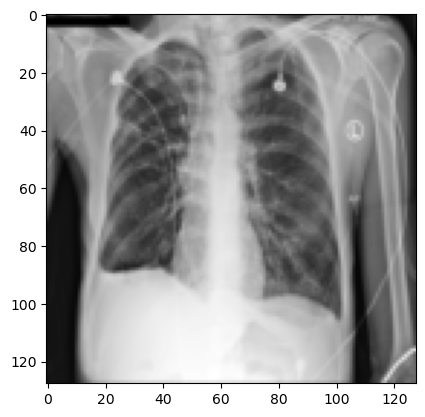

In [3]:
plt.imshow(image, cmap='gray')

In [4]:
image = np.stack((image,)*3, axis=-1)

In [5]:
img = image

b = np.zeros(np.shape(img))

mean = 0
var = 0.15
sigma = var**1.5

# gauss = gauss.reshape(row,col,ch)
# noisy = image + gauss

gauss = np.random.normal(mean,sigma,(img.shape))
gauss = gauss.reshape(img.shape)
b = img + gauss

In [6]:
noisy_image = b

In [7]:
noisy_image.shape

(128, 128, 3)

In [8]:
# Making change in the sample code for bilateral filter

import math

def bilateral2d(img, radius, sigma, sigmaIntensity):
    pad = radius
    # Initialize filtered image to 0
    out = np.zeros_like(img)

    # Pad image to reduce boundary artifacts
    imgPad = np.pad(img, pad)

    # Smoothing kernel, gaussian with standard deviation sigma
    # and size (2*radius+1, 2*radius+1)
    filtSize = (2*radius + 1, 2*radius + 1)
    spatialKernel = fspecial_gaussian_2d(filtSize, sigma)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            centerVal = imgPad[y+pad, x+pad] # Careful of padding amount!

            # Go over a window of size (2*radius + 1) around the current pixel,
            # compute weights, sum the weighted intensity.
            # Don't forget to normalize by the sum of the weights used.
            
            # initializing a weighted intensity array, which will store the value of weights while computing
            weighted_intensity = np.zeros((spatialKernel.shape[0], spatialKernel.shape[1]))
            for r in range(0, 2 * radius+1):
                for c in range(0, 2 * radius+1):
                    current_r = r - radius + y + pad
                    current_c = c - radius + x + pad
                    
                    # Using the formula e^(-x^2 / 2 * sigmaI^2)
                    weighted_intensity[r, c] = math.exp(
                        (-1) * (
                        (imgPad[current_r][current_c] - centerVal)**2) / (2 * math.pow(sigmaIntensity,2)
                    ))

            # getting final bilateral kernel which will be multiplied with the 
            # image pixels to get the missing value        
            bilateral_kernel = weighted_intensity * spatialKernel
            
            
            # dividing by sum of kernel values to normalize the output
            out[y, x] =  np.sum(np.multiply(imgPad[
                y + pad - radius: y + pad + radius + 1, 
                x + pad - radius: x + pad + radius + 1], 
                bilateral_kernel))/np.sum(bilateral_kernel)
    return out 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


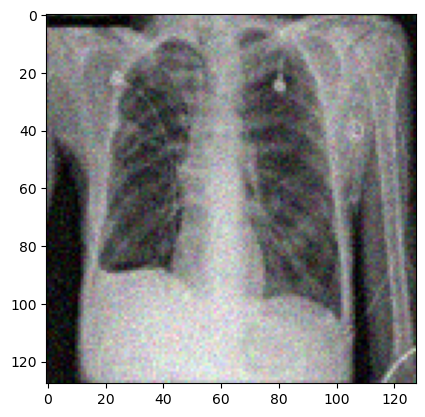

In [9]:
plt.imshow(noisy_image, cmap='gray')

In [10]:
from skimage.filters import gaussian

def fspecial_gaussian_2d(size, sigma):
    kernel = np.zeros(tuple(size))
    kernel[size[0]//2, size[1]//2] = 1
    kernel = gaussian(kernel, sigma)
    return kernel/np.sum(kernel)

In [11]:
# bilateral filter with different sigma intensity

bilateral_filter_images_high_intensity = []

sigma=[1, 2, 3]

for index in range(len(sigma)):

    bilateral = np.zeros_like(noisy_image)
    sigmaIntensity = 0.5

    for channel in [0, 1, 2]:
        bilateral[..., channel] = bilateral2d(noisy_image[..., channel],
                                              radius=int(sigma[index]),
                                              sigma=sigma[index],
                                              sigmaIntensity=sigmaIntensity)
        
    
    bilateral_filter_images_high_intensity.append(bilateral)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


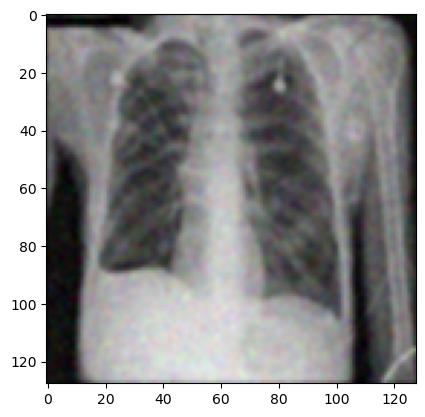

In [12]:
plt.imshow(bilateral_filter_images_high_intensity[0], cmap='gray')

In [13]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [14]:
peak_signal_noise_ratio(image, noisy_image)

24.724112415165415

In [49]:
structural_similarity(image, noisy_image, channel_axis=2)

0.7415660780566987

In [15]:
peak_signal_noise_ratio(image, bilateral_filter_images_high_intensity[0])

30.47626336092599

In [16]:
peak_signal_noise_ratio(image, bilateral_filter_images_high_intensity[1])

28.245225991218415

In [17]:
peak_signal_noise_ratio(image, bilateral_filter_images_high_intensity[2])

26.2156014729527

In [18]:
structural_similarity(image, bilateral_filter_images_high_intensity[0], channel_axis=2)

0.9304976818641664

In [19]:
structural_similarity(image, bilateral_filter_images_high_intensity[1], channel_axis=2)

0.9092532879306505

In [20]:
structural_similarity(image, bilateral_filter_images_high_intensity[2], channel_axis=2)

0.861606671592177

In [21]:
def inbounds(img, y, x):
    return 0 <= y and y < img.shape[0] and \
           0 <= x and x < img.shape[1]

def comparePatches(patch1, patch2, kernel, sigma):
    return np.exp(-np.sum(kernel*(patch1 - patch2) ** 2)/(2*sigma**2))

def nonlocalmeans(img, searchWindowRadius, averageFilterRadius, sigma, nlmSigma):
    # Initialize output to 0
    out = np.zeros_like(img)
    # Pad image to reduce boundary artifacts
    pad = max(averageFilterRadius, searchWindowRadius)
    imgPad = np.pad(img, pad)
    imgPad = imgPad[..., pad:-pad] # Don't pad third channel

    # Smoothing kernel
    filtSize = (2*averageFilterRadius + 1, 2*averageFilterRadius + 1)
    kernel = fspecial_gaussian_2d(filtSize, sigma)
    # Add third axis for broadcasting
    kernel = kernel[:, :, np.newaxis]
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            centerPatch = imgPad[y+pad-averageFilterRadius:y+pad+averageFilterRadius+1,
                                 x+pad-averageFilterRadius:x+pad+averageFilterRadius+1,
                                 :]
            # Go over a window around the current pixel, compute weights
            # based on difference of patches, sum the weighted intensity
            # Hint: Do NOT include the patches centered at the current pixel
            # in this loop, it will throw off the weights
            weights = np.zeros((2*searchWindowRadius+1, 2*searchWindowRadius+1, 1))


            # This makes it a bit better: Add current pixel as well with max weight
            # computed from all other neighborhoods.

            for r in range(-searchWindowRadius, searchWindowRadius+1):
                for c in range(-searchWindowRadius, searchWindowRadius+1):
                    start_row = y+pad+r-averageFilterRadius
                    start_col = x+pad+c-averageFilterRadius
                    end_row = y+pad+r+averageFilterRadius+1
                    end_col = x+pad+c+averageFilterRadius+1
                    
                    # Checking not going out of bound and don't compute on center patch
                    if r != 0 and c != 0 and inbounds(imgPad, start_row, start_col) and inbounds(imgPad, end_row, end_col):
                        
                        patch = imgPad[
                            start_row: end_row, 
                            start_col: end_col, 
                            :]
                        
                        # getting new weight to be assigned to neighbourhood and saving it in an array
                        new_weight = comparePatches(centerPatch, patch, kernel, nlmSigma)
                        weights[r+searchWindowRadius, c+searchWindowRadius, 0] = new_weight
             
            # Max weight to be used by centerPatch
            max_weight = np.amax(weights)
            weights[searchWindowRadius, searchWindowRadius] = max_weight
            
            # Normalizing the weights
            weights = weights/np.sum(weights)
            neighbourhood = imgPad[y+pad-searchWindowRadius: y+pad+searchWindowRadius+1, x+pad-searchWindowRadius: x+pad+searchWindowRadius+1,:]
            
            result = np.multiply(weights, neighbourhood)

            out[y, x, :] = np.sum(result, axis=(0,1)) 
    return out

In [22]:
sigma=[1, 2, 3]

nlm_filter_images = []

for index in range(len(sigma)):
    nlmSigma = 0.1
    searchWindowRadius = 2
    averageFilterRadius = int(sigma[index])
    nlm = np.zeros_like(noisy_image)
    for channel in [0,1,2]:
        nlm[...,channel:channel+1] = nonlocalmeans(noisy_image[..., channel:channel+1],
                                                   searchWindowRadius,
                                                   averageFilterRadius,
                                                   sigma[index],
                                                   nlmSigma)
        
    nlm_filter_images.append(nlm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


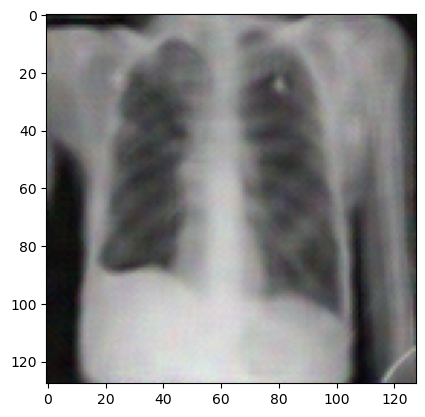

In [23]:
plt.imshow(nlm_filter_images[2], cmap='gray')

In [24]:
peak_signal_noise_ratio(image, noisy_image)

24.724112415165415

In [25]:
nlm_filter_images[0].shape

(128, 128, 3)

In [26]:
peak_signal_noise_ratio(image, nlm_filter_images[0])

29.04854568574499

In [27]:
peak_signal_noise_ratio(image, nlm_filter_images[1])

28.070972527894863

In [28]:
peak_signal_noise_ratio(image , nlm_filter_images[2])

27.660531344874464

In [29]:
structural_similarity(image, nlm_filter_images[0], channel_axis=2)

0.9076870416059103

In [30]:
structural_similarity(image, nlm_filter_images[1], channel_axis=2)

0.8892471214985235

In [31]:
structural_similarity(image, nlm_filter_images[2], channel_axis=2)

0.8806302067118409

In [32]:
# applying the gaussian filter on the noisy image
import scipy.signal

sigma = [0.5, 1, 2 , 3]

gaussian_images = []

for index in range(len(sigma)):
    # creating the kernel using fspecial_gaussian_2d
    kernel = fspecial_gaussian_2d((9,9), sigma[index])

    # seperating the three channels
    noisy_image_red = noisy_image[:,:,0]
    noisy_image_green = noisy_image[:,:,1]
    noisy_image_blue = noisy_image[:,:,2]

    # convolving each channel with the gaussian kernel
    new_image_r = scipy.signal.convolve2d(noisy_image_red, kernel, mode="same")
    new_image_g = scipy.signal.convolve2d(noisy_image_green, kernel, mode="same")
    new_image_b = scipy.signal.convolve2d(noisy_image_blue, kernel, mode="same")

    # final image obtained by combining the three channels
    new_image = np.dstack((new_image_r, new_image_g, new_image_b))
    
    gaussian_images.append(new_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


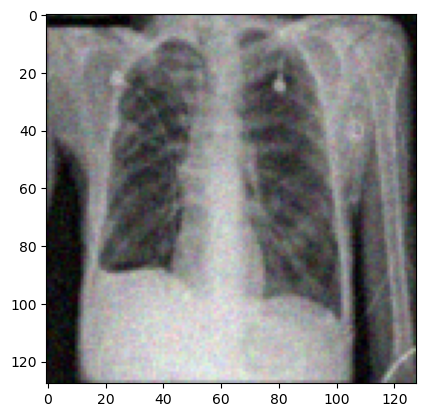

In [33]:
plt.imshow(gaussian_images[0], cmap='gray')

In [34]:
peak_signal_noise_ratio(image, gaussian_images[0])

28.212027365294794

In [35]:
peak_signal_noise_ratio(image, gaussian_images[1])

28.709397125868648

In [36]:
peak_signal_noise_ratio(image, gaussian_images[2])

24.863724865260878

In [37]:
peak_signal_noise_ratio(image, gaussian_images[3])

23.425488784554016

In [38]:
structural_similarity(image, gaussian_images[0], channel_axis=2)

0.862062765725863

In [39]:
structural_similarity(image, gaussian_images[1], channel_axis=2)

0.927479805369229

In [40]:
structural_similarity(image, gaussian_images[2], channel_axis=2)

0.8536018376749896

In [41]:
# applying the median filter on the noisy image
import scipy

sizes = [7, 8, 9]

median_filter_images = []

noisy_image_red = noisy_image[:, :, 0]
noisy_image_green = noisy_image[:, :, 1]
noisy_image_blue = noisy_image[:, :, 2]

for index in range(len(sizes)):

    # Applying median filter on each channel in R, G, B
    new_image_median_r = scipy.ndimage.median_filter(noisy_image_red, size=sizes[index])
    new_image_median_g = scipy.ndimage.median_filter(noisy_image_green, size=sizes[index])
    new_image_median_b = scipy.ndimage.median_filter(noisy_image_blue, size=sizes[index])

    # Combining all the channels
    new_image_median = np.dstack((new_image_median_r, new_image_median_g, new_image_median_b))
    
    median_filter_images.append(new_image_median)

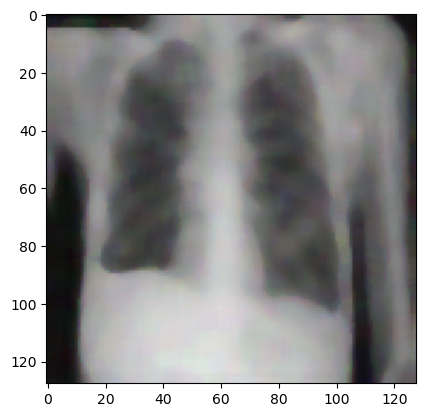

In [42]:
plt.imshow(median_filter_images[0], cmap='gray')

In [43]:
peak_signal_noise_ratio(image, median_filter_images[0])

26.420414398399693

In [44]:
peak_signal_noise_ratio(image, median_filter_images[1])

25.142963396344115

In [45]:
peak_signal_noise_ratio(image, median_filter_images[2])

24.854195644765944

In [46]:
structural_similarity(image, median_filter_images[0], channel_axis=2)

0.8487591128813355

In [47]:
structural_similarity(image, median_filter_images[1], channel_axis=2)

0.8178624281052609

In [48]:
structural_similarity(image, median_filter_images[2], channel_axis=2)

0.803810170768982